<a href="https://colab.research.google.com/github/TrynowPht/TPMachineLearning/blob/master/TP_MachinLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
#@title Importación de Librerías
import pandas as pd
import missingno as msno
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from ipywidgets import FileUpload
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
%matplotlib inline

### Lectura de la Data

In [32]:
DataSet = FileUpload()
DataSet

FileUpload(value={}, description='Upload')

In [124]:
with open('datos_banco.csv', "wb") as fp:
    fp.write(DataSet.data[0])
df = pd.read_csv("datos_banco.csv", engine='python')
df.head(5)

,idPrestamo,target,monthly_debt_capacity,var_employment_time_in_months,approved_amount,approved_term,approved_interest_amount,var_net_income,person_gender,credit_history_marital_status,var_max_sbs_qual_12m,person_degree_type_desc,default_request_term,default_request_amount
0,LIBDISP9832897855,1,252.39,9.0,"1,200",6,289.11,1140.125000,MALE,C,NORMAL,Secundaria,1,0
1,LIBDISP9021501745,1,244.57,50.0,"2,200",12,696.15,1061.375000,FEMALE,S,NORMAL,Secundaria,0,0
2,LIBDISP4057314971,0,491.5,64.0,"1,000",3,84.99,2082.196667,FEMALE,S,NORMAL,Secundaria,0,0
3,LIBDISP8375185888,0,848.65,77.0,"1,500",6,221.53,3422.423333,MALE,S,NORMAL,Universitaria,0,0
4,LIBDISP9694463037,0,470.52,82.0,"1,000",3,91.34,1882.090000,FEMALE,S,NORMAL,Universitaria,1,0


La data a utilizar es un dataframe, es decir, un conjunto de datos organizados en estructuras rectangulares en forma de tabla o matriz, el cual contiene distintos tipos de datos y están organizados por columnas con su atributo correspondiente. Considerando esto podemos decir que la data es de tipo estructurada.

## 1. Análisis Exploratorio

### 1.1 Cantidad de variables y atributos

In [125]:
print('Cantidad de instancias:',df.shape[0])
print('Cantidad de atributos:',df.shape[1])

Cantidad de instancias: 1719
Cantidad de atributos: 14


### 1.2 Valores nulos

En el siguiente gráfico podemos ver la existencia de valores nulos a lo largo de cada instancia, como resultado podemos observar que solo el atributo ***var_employment_time_in_month*** contiene valores nulos.

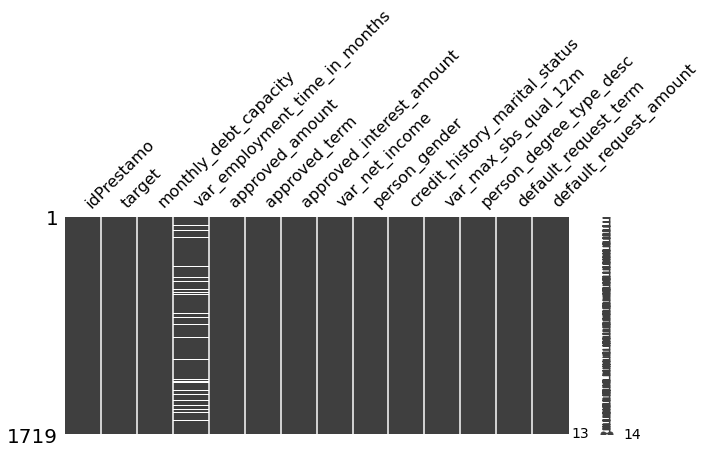

In [126]:
msno.matrix(df, figsize=(10,4));

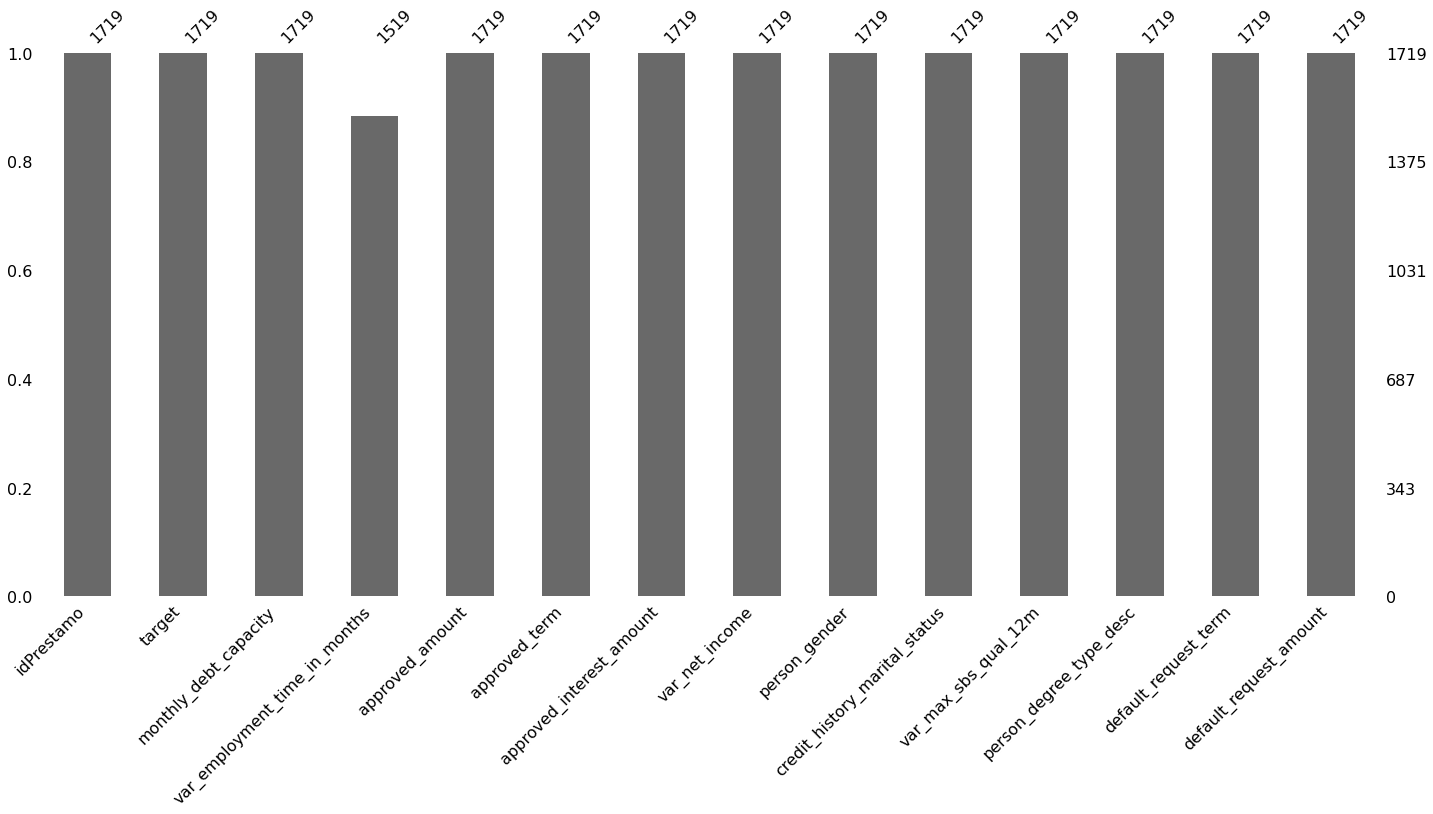

In [127]:
msno.bar(df) 

Obtenemos la cantidad exacta de valores nulos en el dataframe, podemos concluir que la proporción de datos nulos es bastante ***reducida***.

In [128]:
df.isna().sum()

idPrestamo                         0
target                             0
monthly_debt_capacity              0
var_employment_time_in_months    200
approved_amount                    0
approved_term                      0
approved_interest_amount           0
var_net_income                     0
person_gender                      0
credit_history_marital_status      0
var_max_sbs_qual_12m               0
person_degree_type_desc            0
default_request_term               0
default_request_amount             0
dtype: int64

### 1.3 Atributos

A continuación, podemos observar la lista de atributos del dataset, junto con su tipo de dato. Además, podemos determinar el conjunto de atributos que podrían aportar valor significativo a nuestro modelo y aquellos que no.



In [129]:
df.dtypes

idPrestamo                        object
target                             int64
monthly_debt_capacity             object
var_employment_time_in_months    float64
approved_amount                   object
approved_term                      int64
approved_interest_amount          object
var_net_income                   float64
person_gender                     object
credit_history_marital_status     object
var_max_sbs_qual_12m              object
person_degree_type_desc           object
default_request_term               int64
default_request_amount             int64
dtype: object

Podemos observar además que variables con tipos de dato que no corresponden al valor que se muestra en el dataframe. Tal es el caso de **monthly_debt_capacity**, **approved_amount** y **approved_interest_amount**

In [130]:
df.describe()

,target,var_employment_time_in_months,approved_term,var_net_income,default_request_term,default_request_amount
count,1719.000000,1519.000000,1719.000000,1719.000000,1719.000000,1719.0
mean,0.295521,33.979592,6.464805,2693.545884,0.507853,0.0
std,0.456409,26.889423,3.009842,1825.694773,0.500084,0.0
min,0.000000,-1.000000,1.000000,0.000000,0.000000,0.0
25%,0.000000,11.000000,6.000000,1750.000000,0.000000,0.0
50%,0.000000,26.000000,6.000000,2373.758333,1.000000,0.0
75%,1.000000,61.000000,6.000000,3075.133333,1.000000,0.0
max,1.000000,87.000000,12.000000,28587.000000,1.000000,0.0


### 1.4. Atributos categóricos

El dataset contiene 3 atributos categóricos (***credit_history_marital_status***	***var_max_sbs_qual_12m*** y	***person_degree_type_desc***). Haremos un análisis exploratorio en ellos con la finalidad de descubrir particularidades.

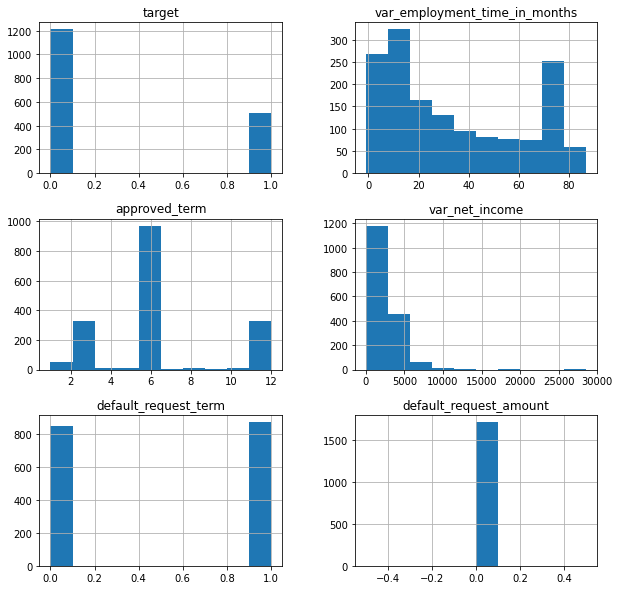

In [131]:
df.hist(figsize=(10,10));

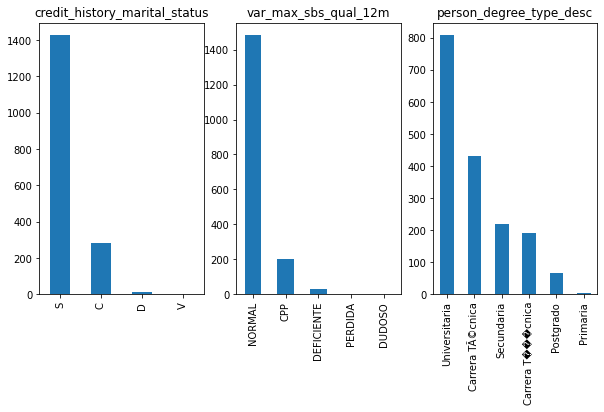

In [132]:
atrib_cat = ['credit_history_marital_status', 'var_max_sbs_qual_12m', 'person_degree_type_desc']

fig, ax = plt.subplots(1, len(atrib_cat), figsize=(10,5))
for i, categorical_feature in enumerate(df[atrib_cat]):
    df[categorical_feature].value_counts().plot(kind='bar', ax=ax[i]).set_title(categorical_feature)
fig.show()

En el gráfico de barras anterior, podemos visualizar que la *categoría carrera* técnica del atributo ***person_degree_type_desc*** se repite varias veces con nombres similares, por lo que deberemos reemplazar en una sola y unir los registro que presente dicha categoría.

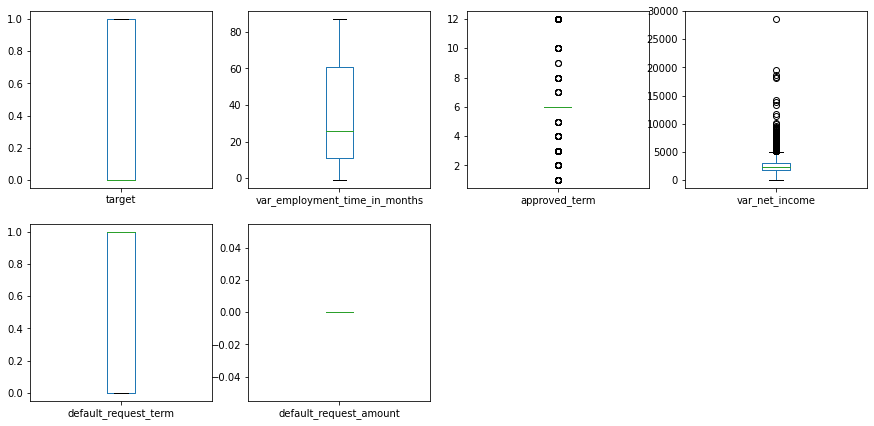

In [133]:
df.plot(kind='box', subplots = True, layout=(4,4), figsize=(15,15));

Con estos gráficos de cajas podemos analizar los outlaiers respecto a cada atributo y si es necesario ralizar alguna eliminación de registros

### 1.5 Atributo Clase
 
En el siguiente gráfico podemos observar la proporción de instancias del atributo clase del dataset (***target***)

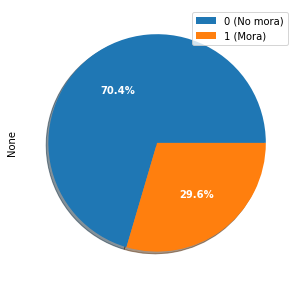

In [134]:
df.groupby(['target']).size().plot(kind='pie', legend=True, figsize = (5,5), labels=['0 (No mora)', '1 (Mora)'], autopct='%1.1f%%', shadow=True, textprops={'color':"w", 'weight':"bold"});

### 1.6. Registros duplicados
Para el análisis de data duplicada utilizaremos **duplicated().sum()** el cual nos permitirá identificar si existen registros que tienen los mismo atributos que otro dentro del mismo dataframe.


In [135]:
df.duplicated().sum()

0

## 2. Tratamiento de Datos




### 2.1. Cast de Atributos

Como podemos ver, muchas de las *variables* continen *valores numéricos*; ***sin embargo***, algunas de ellas (***monthly_deb_capacity***, ***approved_amounts***, ***approved_interest_amount***) no son reconocidas como tal en el entorno de ejecución. Por ello, se hará un *cast* de dichos valores

In [136]:
atribs_obj = ['monthly_debt_capacity', 'approved_amount', 'approved_interest_amount']

for atrib in atribs_obj:
  df[atrib] = df[atrib].str.replace(',', '', regex=True)
  df[atrib] = pd.to_numeric(df[atrib], downcast="float")

In [137]:
df.dtypes

idPrestamo                        object
target                             int64
monthly_debt_capacity            float32
var_employment_time_in_months    float64
approved_amount                  float32
approved_term                      int64
approved_interest_amount         float32
var_net_income                   float64
person_gender                     object
credit_history_marital_status     object
var_max_sbs_qual_12m              object
person_degree_type_desc           object
default_request_term               int64
default_request_amount             int64
dtype: object

Como podemos observar, los tipos de datos han sido convertidos a float para su manejabilidad

### 2.2. Descartando atributos

Luego del análisis de variables, podemos descartar algunas que no aportarían valor a nuestro modelo. Estas son:

1.   **idPrestamo**: Identificador de Préstamo
2.   **person_gender**: Género de la persona que solicito el préstamo
3. **default_request_amount**: Si escogio el monto de dinero ofrecido (según muestra el histograma anterior, todos los valores son 0)


In [138]:
df = df.drop(["idPrestamo", "person_gender", "default_request_amount"], axis=1)

In [139]:
df.columns.shape[0]

11

**df.columns.shape[0]** nos indica la cantidad de atributos actuales. Ya que se eliminaron tres columnas del dataframe obtenemos como resultado 11 (anteriormente 14 columnas)

### 2.3. Corrección de Carrera Ténica
Tomando en referencia el análisis realizado en la sección 1.4. de atributos categóricos, debemos de realizar la corrección en cuestión

In [140]:
df["person_degree_type_desc"] = np.where(df["person_degree_type_desc"].str.contains('Carrera'), 'Carrera Tecnica', df["person_degree_type_desc"])

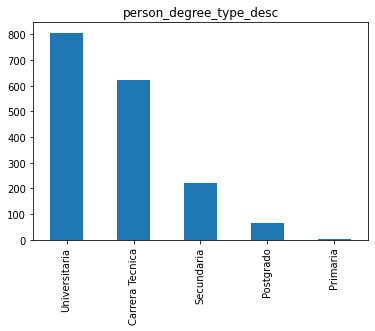

In [141]:
df['person_degree_type_desc'].value_counts().plot(kind='bar').set_title('person_degree_type_desc')
plt.show()

Podemos obserbar que ahora sí solo existe una sola categoría Carrera Técnica que engobla las categorías con errores

### 2.4. Conversión de Atributos categóricos

Para convertir los atributos categóricos utilizaremos ***One Hot Encoding***, al ser reemplazados con este algoritmo, serán eliminados del dataset.

In [142]:
atribs_prefix = ['chm', 'vms', 'pdt']

# One Hot Encoding
for prefixs, atrib in zip(atribs_prefix, atrib_cat):
  ohe = pd.get_dummies(df[atrib], prefix=prefixs)
  df = pd.concat([df, ohe], axis = 1)

# Eliminando atributos
for atrib in atrib_cat:
  df = df.drop(columns=[atrib])

df.head(5)

,target,monthly_debt_capacity,var_employment_time_in_months,approved_amount,approved_term,approved_interest_amount,var_net_income,default_request_term,chm_C,chm_D,chm_S,chm_V,vms_CPP,vms_DEFICIENTE,vms_DUDOSO,vms_NORMAL,vms_PERDIDA,pdt_Carrera Tecnica,pdt_Postgrado,pdt_Primaria,pdt_Secundaria,pdt_Universitaria
0,1,252.389999,9.0,1200.0,6,289.109985,1140.125000,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0
1,1,244.570007,50.0,2200.0,12,696.150024,1061.375000,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
2,0,491.500000,64.0,1000.0,3,84.989998,2082.196667,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
3,0,848.650024,77.0,1500.0,6,221.529999,3422.423333,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1
4,0,470.519989,82.0,1000.0,3,91.339996,1882.090000,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1


In [143]:
print('Nueva cantidad de atributos:',df.shape[1])
print(df.dtypes)

Nueva cantidad de atributos: 22
target                             int64
monthly_debt_capacity            float32
var_employment_time_in_months    float64
approved_amount                  float32
approved_term                      int64
approved_interest_amount         float32
var_net_income                   float64
default_request_term               int64
chm_C                              uint8
chm_D                              uint8
chm_S                              uint8
chm_V                              uint8
vms_CPP                            uint8
vms_DEFICIENTE                     uint8
vms_DUDOSO                         uint8
vms_NORMAL                         uint8
vms_PERDIDA                        uint8
pdt_Carrera Tecnica                uint8
pdt_Postgrado                      uint8
pdt_Primaria                       uint8
pdt_Secundaria                     uint8
pdt_Universitaria                  uint8
dtype: object


Como podemos observar, la cantidad de atributos aumentan (columnas) a partir de la implementación del ***One Hot Encoding***.

### 2.5. Sustitución de valores nulos
La función sklearn.impute.SimpleImputer permite sustituir valores nulos por otros valores según varias estrategias disponibles. La estrategia a ejecutar se indica mediante el parámetro strategy.

En este caso el ***atributo var_employment_time_in_months*** tenia valores NA la estrategia es sustituir los valores nulos por el valor medio de las características

In [144]:
from sklearn.impute import SimpleImputer
si = SimpleImputer()

df["var_employment_time_in_months"] = si.fit_transform(df["var_employment_time_in_months"].values.reshape(-1, 1))

df.head(11)
df.describe()

,target,monthly_debt_capacity,var_employment_time_in_months,approved_amount,approved_term,approved_interest_amount,var_net_income,default_request_term,chm_C,chm_D,chm_S,chm_V,vms_CPP,vms_DEFICIENTE,vms_DUDOSO,vms_NORMAL,vms_PERDIDA,pdt_Carrera Tecnica,pdt_Postgrado,pdt_Primaria,pdt_Secundaria,pdt_Universitaria
count,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000
mean,0.295521,584.639282,33.979592,2136.998291,6.464805,407.184509,2693.545884,0.507853,0.162885,0.007563,0.828970,0.000582,0.117510,0.018034,0.000582,0.861547,0.002327,0.363002,0.037813,0.001745,0.127981,0.469459
std,0.456409,459.958984,25.275851,1504.947632,3.009842,407.703125,1825.694773,0.500084,0.369369,0.086659,0.376644,0.024119,0.322121,0.133112,0.024119,0.345475,0.048196,0.481005,0.190798,0.041751,0.334166,0.499212
min,0.000000,-158.750000,-1.000000,500.000000,1.000000,22.820000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,350.760010,12.000000,1000.000000,6.000000,152.320007,1750.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,480.739990,33.000000,1500.000000,6.000000,281.390015,2373.758333,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,660.820007,55.000000,2500.000000,6.000000,429.799988,3075.133333,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,7243.200195,87.000000,12200.000000,12.000000,2311.120117,28587.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### 2.6. Outliers 
  En este caso identificamos en la variable var_net_income (salario) presentaba valores atipicos a partir del analisis del diagrama de cajas. Identificamos el valor Max a partir de los percentiles 25 y 75. Se utiliza los imputers para rellenar los valores atipicos.


1750.0 3075.1333335 5062.83333375


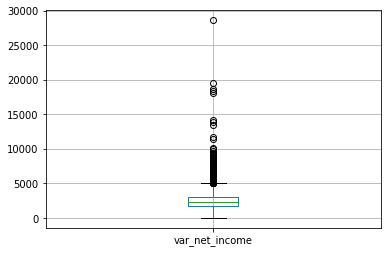

In [145]:
Q1 =  df['var_net_income'].quantile(0.25)
Q3 = df['var_net_income'].quantile(0.75)
IQR = Q3 - Q1

Max = Q3+1.5*IQR

boxplot = df.boxplot(column=['var_net_income'])

df.loc[(df['var_net_income'] > Max)] = None

print(Q1,Q3,Max)

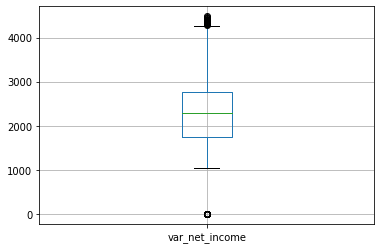

In [146]:
df['var_net_income'].describe()

df.loc[(df['var_net_income'] > Max)] = None

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')


df["var_net_income"] = imp_mean.fit_transform(df["var_net_income"].values.reshape(-1, 1))

boxplot = dcv.boxplot(column=['var_net_income'])
df["var_net_income"].describe()

df = df.dropna()

### 2.7 Normalización de datos

Utilizaremos la ***MinMaxScaler*** para normalizar nuestros datos para los modelos

In [147]:
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df.head(5)

,target,monthly_debt_capacity,var_employment_time_in_months,approved_amount,approved_term,approved_interest_amount,var_net_income,default_request_term,chm_C,chm_D,chm_S,chm_V,vms_CPP,vms_DEFICIENTE,vms_DUDOSO,vms_NORMAL,vms_PERDIDA,pdt_Carrera Tecnica,pdt_Postgrado,pdt_Primaria,pdt_Secundaria,pdt_Universitaria
0,1.0,0.252037,0.113636,0.064815,0.454545,0.116370,0.225366,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.247243,0.579545,0.157407,1.000000,0.294249,0.209799,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.398616,0.738636,0.046296,0.181818,0.027169,0.411583,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.617556,0.886364,0.092593,0.454545,0.086837,0.676502,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.385755,0.943182,0.046296,0.181818,0.029944,0.372028,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


### 2.8 Separación de datos en subconjuntos

Para que nuestros modelos puedan procesar los datos, los separaremos en subconjuntos, X contendrá los atributos mientras y contendrá el atributo clase

In [148]:
X = df[[x for x in df.columns if x != 'target']]
y = pd.to_numeric(df['target'], downcast="integer")

## 3. Aplicación de modelos para clasificación

### 3.1 Gaussian Naive Bayes

In [159]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

gnb = GaussianNB()
gnb.fit(X_train, y_train)

X_gnb_predict = gnb.predict(X_test)

print(classification_report(X_gnb_predict, y_test))

scores_gnb = cross_val_score(gnb, X_train, y_train, cv=15)
print("Accuracy promedio: ", np.mean(scores_gnb))

              precision    recall  f1-score   support

           0       0.05      0.88      0.09        25
           1       0.98      0.29      0.45       617

    accuracy                           0.32       642
   macro avg       0.52      0.59      0.27       642
weighted avg       0.95      0.32      0.44       642

Accuracy promedio:  0.33852564102564103


### 3.2 Multinomial Naive Bayes

In [160]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)

X_mnb_predict = mnb.predict(X_test)

print(classification_report(X_mnb_predict, y_test))

scores_mnb = cross_val_score(mnb, X_train, y_train, cv=15)
print("Accuracy promedio: ", np.mean(scores_mnb))

              precision    recall  f1-score   support

           0       0.98      0.72      0.83       620
           1       0.06      0.50      0.11        22

    accuracy                           0.71       642
   macro avg       0.52      0.61      0.47       642
weighted avg       0.94      0.71      0.80       642

Accuracy promedio:  0.6947435897435897
